In [8]:
import random
import os
! pip3 install opencv-python
import cv2
import torch

import numpy as np
import matplotlib.pyplot as plt

from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from load_data import load_specific_dataset, load_dataset, split_dataset
from torch.utils.data import random_split


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# --------------------- für direktes Testing ----------------------------
dataset = load_specific_dataset()
train_dataset, val_dataset, test_dataset = split_dataset(dataset, train_size=0.01, val_size=0.01)
batch_size = 512

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Ordner 'data\alzheimers_dataset': 2500 Bilder
Ordner 'data\normal': 2089 Bilder


#### Normal: Alle die mit 'non_' anfangen
#### Alzheimers: Alle die mit 'mild_' oder 'verymild_' anfangen

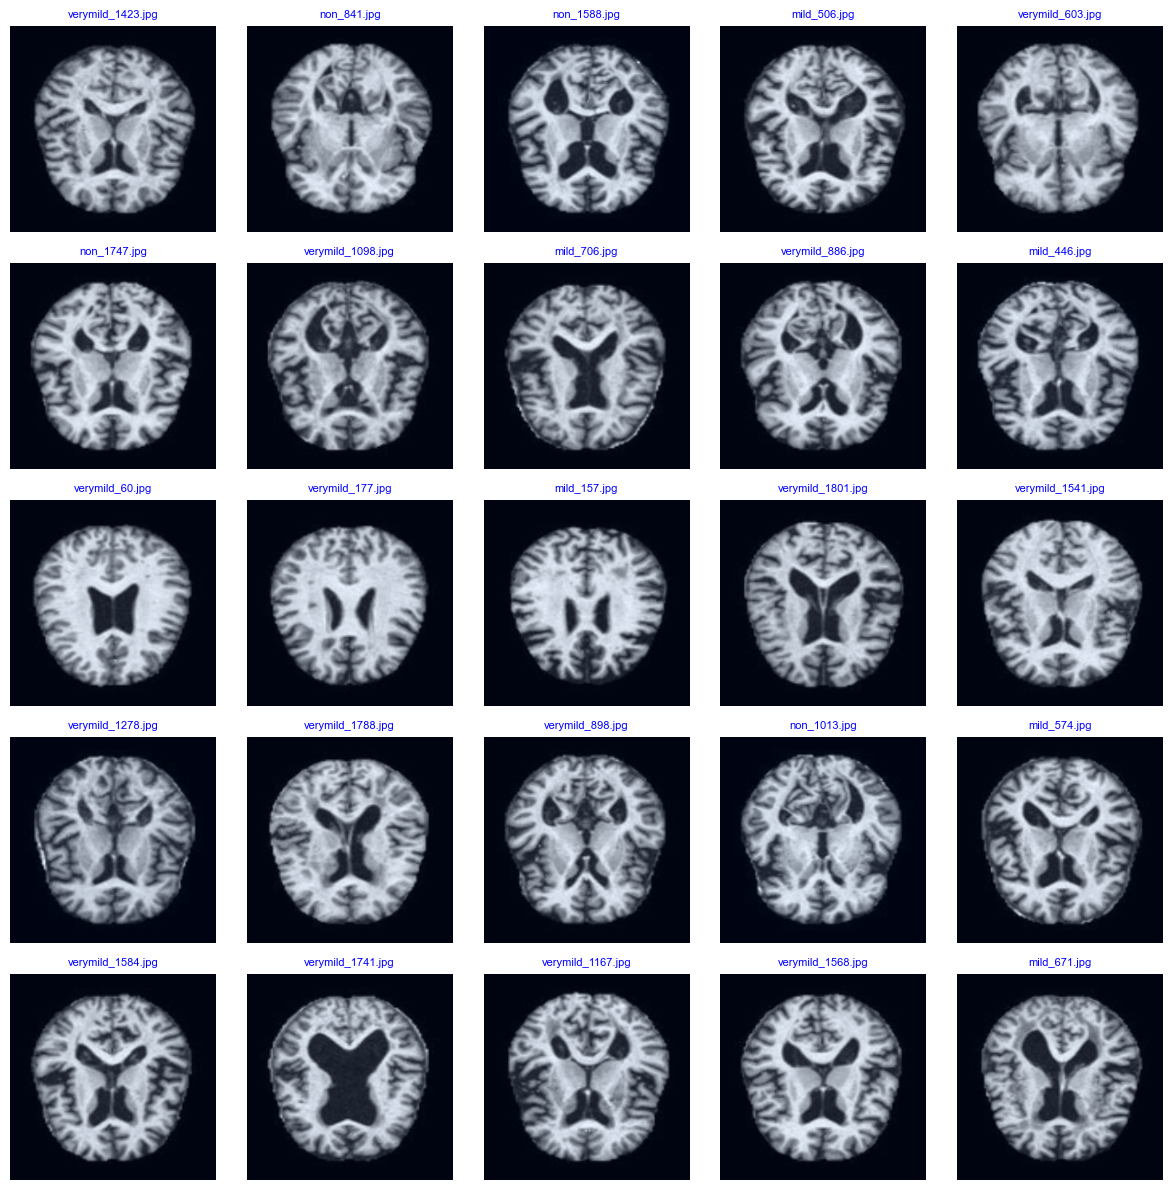

In [10]:
# Select random images from the dataset
random_indices = random.sample(range(len(dataset)), 25)
images = [dataset[i][0] for i in random_indices]  # Extract only the image tensor
filenames = [os.path.basename(dataset.samples[i][0]) for i in random_indices]  # Get filenames

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
    img = images[i].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C) for plt

    if img.min() < 0 or img.max() > 1:
        img = (img - img.min()) / (img.max() - img.min())

    ax.imshow(img)
    ax.axis('off') 
    ax.set_title(filenames[i], fontsize=8, color='blue')

plt.tight_layout()
plt.show()


In [11]:
# --------- Modell erstellen: Achtung muss mit zu ladendem Model übereinstimmen! -----------
class CNNModel(nn.Module):
    def __init__(self, num_classes=2):  # 2 Klassen: normal, Alzheimer
        super(CNNModel, self).__init__()
        self.layers = nn.Sequential(
            
            # Erste Convolutional-Schicht: 3 Eingabekanäle (RGB), 16 Filter, 3x3 Kernel
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), #Reduziert Rechenaufwand
            
            # Zweite Convolutional-Schicht: 16 Eingabekanäle, 32 Filter, 3x3 Kernel
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Dritte Convolutional-Schicht: 32 Eingabekanäle, 64 Filter, 3x3 Kernel
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Flatten für den Übergang in die Fully Connected Layers
            nn.Flatten(),
            
            # Fully Connected-Schicht
            nn.Linear(64 * 28 * 28, 512),  # Bilder sollten vor Training auf 224x224 verkleinert
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout für Regularisierung
            
            # Zweite Fully Connected-Schicht, die zu den Klassen führt
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Definiere den Vorwärtsdurchlauf durch die Schichten
        return self.layers(x)


model = CNNModel()
model

CNNModel(
  (layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=50176, out_features=512, bias=True)
    (11): ReLU()
    (12): Dropout(p=0.5, inplace=False)
    (13): Linear(in_features=512, out_features=2, bias=True)
  )
)

In [12]:
loaded_model = CNNModel()
loaded_model.load_state_dict(torch.load('trained_model', weights_only=True))

<All keys matched successfully>

In [13]:
# Nach dem Training: Testen des Modells
model.eval()
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    for images, labels in test_loader:
        # Vorhersage und Verlustberechnung
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Vorhersagen und Labels für Confusion Matrix speichern
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Testgenauigkeit und -verlust berechnen
test_accuracy = 100 * correct / total
test_loss = test_loss / len(test_loader)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


KeyboardInterrupt: 

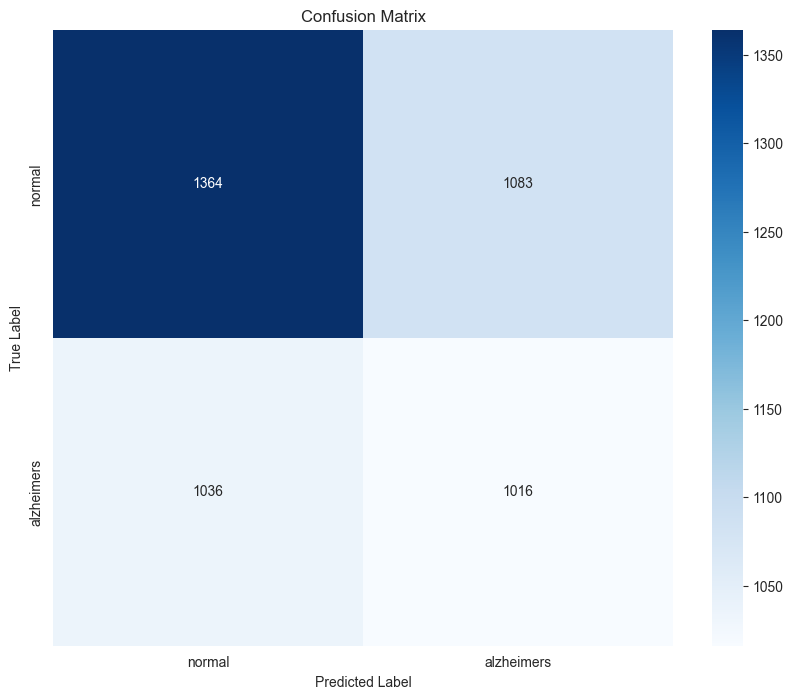

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
class_names = ['normal', 'alzheimers']

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
